In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse
import copy

plt.style.use('sarah_plt_style.mplstyle')

Lets use a non-idea example image (includes other objects in the image and has some uneven brightness across the image)

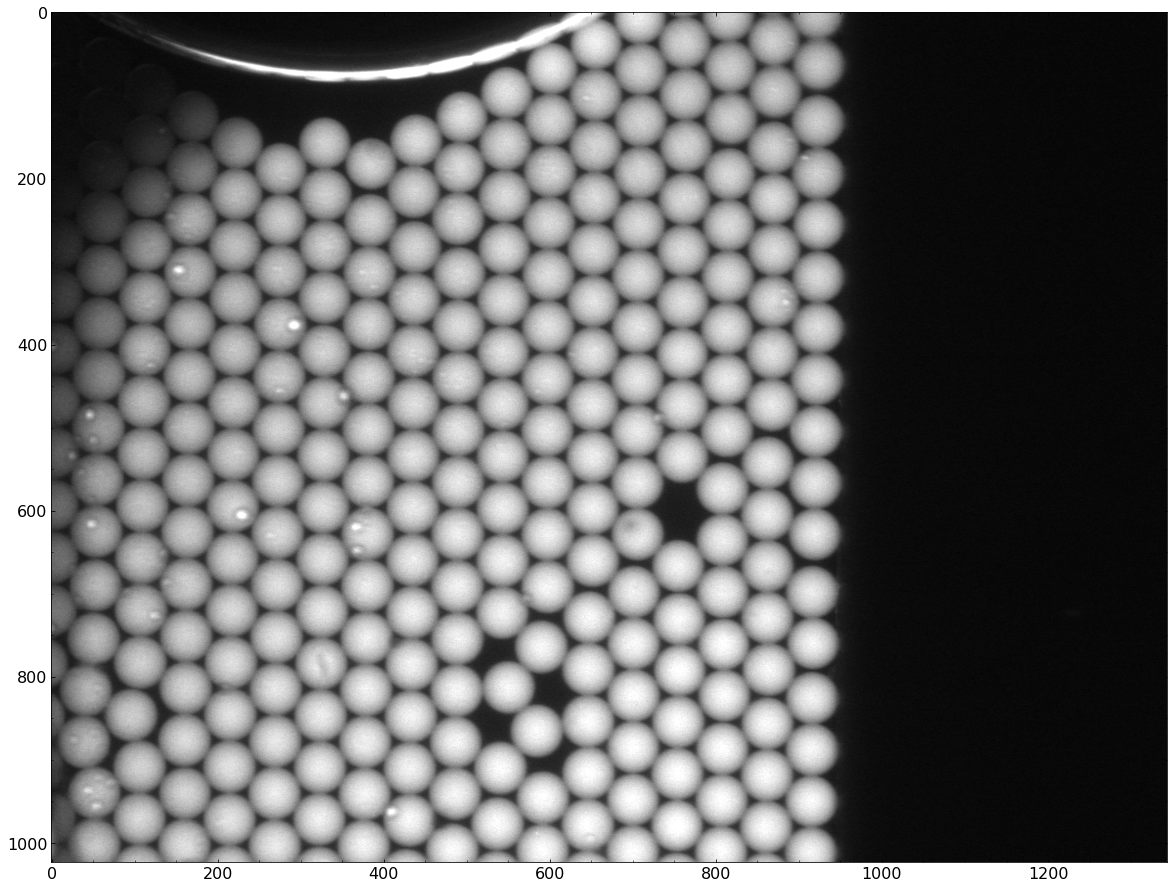

In [2]:
#change and get current working directory (cwd)
os.chdir('{}\Images'.format(os.getcwd()))
image_dir = os.getcwd()

#load image files
image = plt.imread('{}\\20220818\example_image.tif'.format(image_dir))

fig, ax = plt.subplots(figsize = (20, 20))
ax.imshow(image, cmap = 'gray')
plt.show()

HoughCircles appears to be the standard for using python to find circles in images, but it is pretty sensitive to the parameters. Even once I get the parameters as optimal as I can manage (middle image below) it does a good idea of finding circles, but not properly outlining them. However if I binerize the image first to get rid of the internal variation in brightness HoughCircles does a much better job of finding the correct outline and catches fewer random things I assume are from noise.

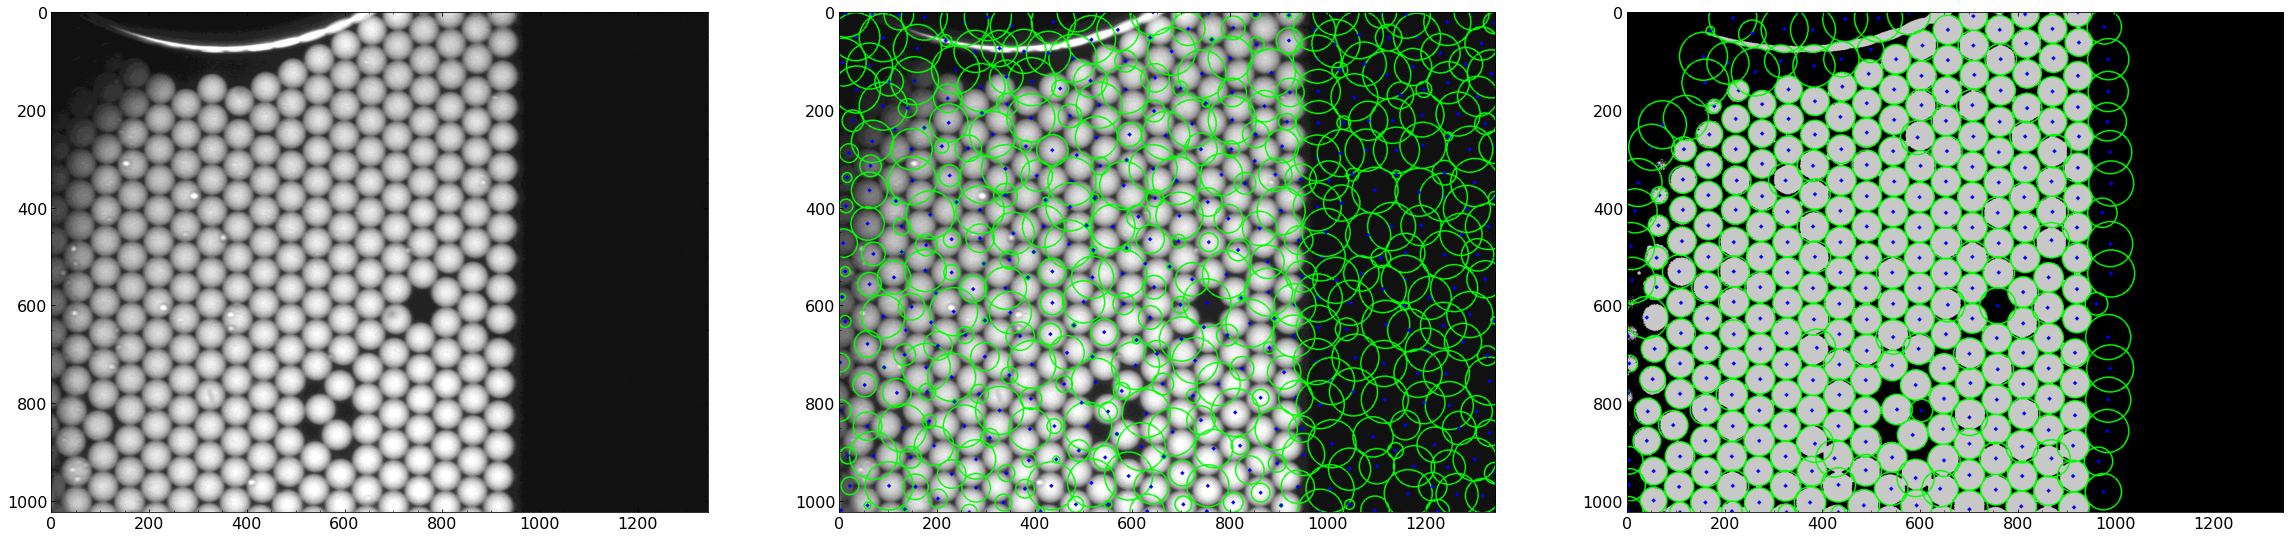

In [425]:
def find_bright_pixels(cutoff, pixel_value):
    if pixel_value > cutoff:
        return 1 #bright pixel
    else:
        return 0 #not bright pixel
    
find_bright_pixels = np.vectorize(find_bright_pixels, excluded=[0])

image = cv.imread('{}\\20220818\example_image.tif'.format(image_dir), 0)

color_img = cv.cvtColor(image,cv.COLOR_GRAY2BGR) * 17
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    cv.circle(color_img,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(color_img,(i[0],i[1]),2,(0,0,255),3)

th, bin_image = cv.threshold(image, 6, 1, cv.THRESH_BINARY)
bin_color_img = cv.cvtColor(bin_image,cv.COLOR_GRAY2BGR) *200
bin_circles = cv.HoughCircles(bin_image, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
bin_circles = np.uint16(np.around(bin_circles))
for i in bin_circles[0,:]:
    cv.circle(bin_color_img,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(bin_color_img,(i[0],i[1]),2,(0,0,255),3)

fig, axs = plt.subplots(1, 3, figsize = (40,20))
axs[0].imshow(image, cmap = 'gray')
axs[1].imshow(color_img, cmap = 'gray')
axs[2].imshow(bin_color_img, cmap = 'gray')

plt.show()

Now we need to figure out how to filter out the circles that are not highlighting droplets. To do this we need to find all of the points in a given circle.

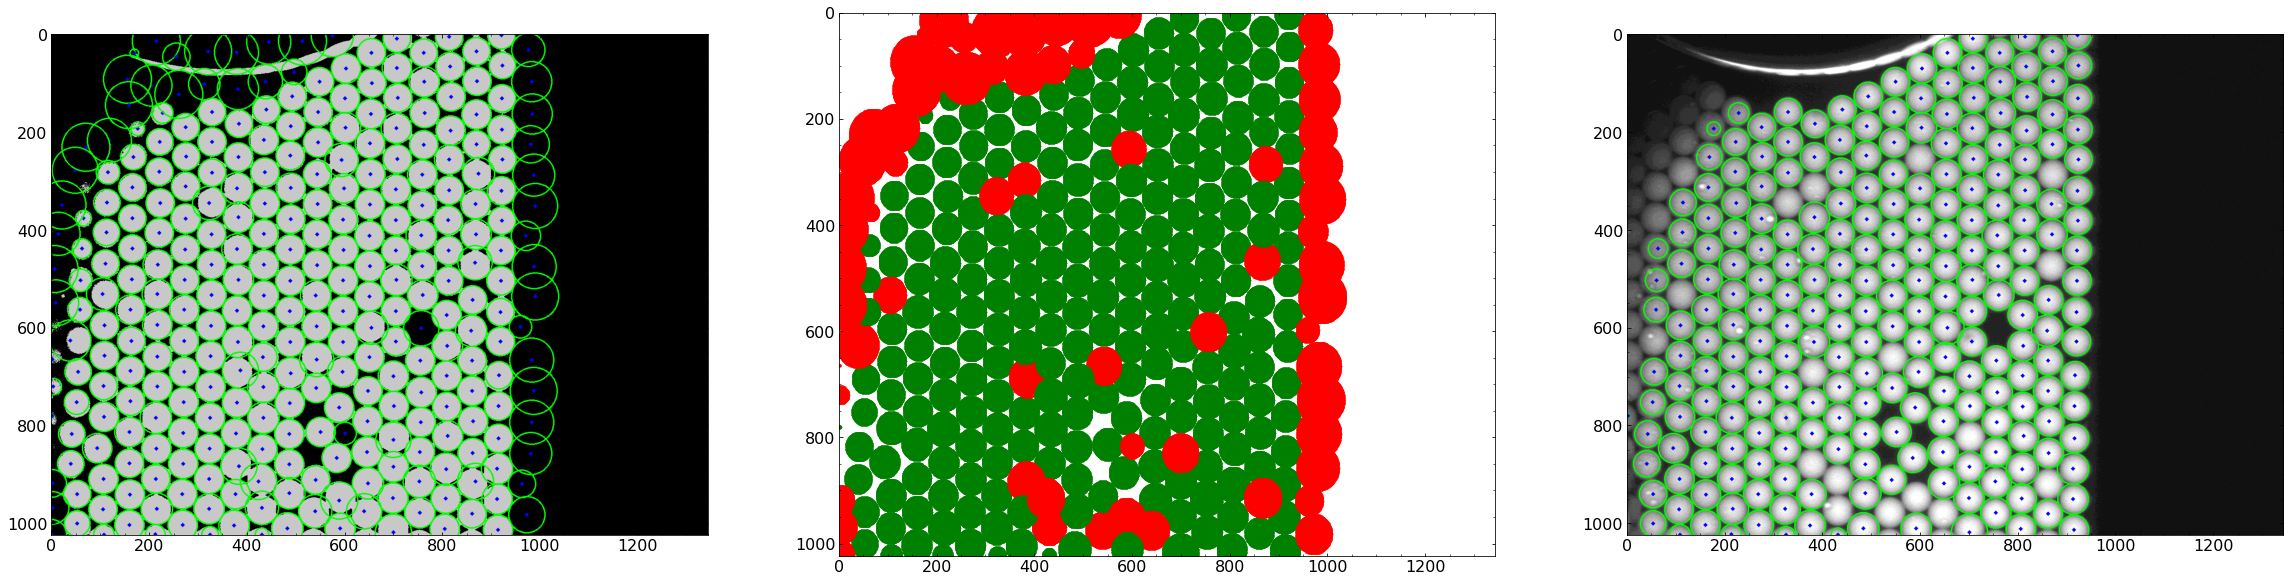

In [430]:
def find_pixels_in_circle(cir_par):
    points = []
    cx, cy, r = cir_par
    for y in range(-1 *  r, +r+1):
        x = (r**2 - y**2)**0.5

        x1 = int(-x + cx)
        x2 = int(+x + cx)
    
        y = y + cy
        for x in range(x1, x2):
            if x < 1344 and y < 1024: #don't keep a point if it falls outside the image size
                points.append([x,y])
    return points

th, bin_image = cv.threshold(image, 6, 1, cv.THRESH_BINARY)
bin_color_img = cv.cvtColor(bin_image,cv.COLOR_GRAY2BGR) *200
color_img = cv.cvtColor(image,cv.COLOR_GRAY2BGR) * 17
bin_circles = cv.HoughCircles(bin_image, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
bin_circles = np.uint16(bin_circles)

fig, axs = plt.subplots(1, 3, figsize = (40,10))

radi = []
for i in bin_circles[0,:]:
    cv.circle(bin_color_img,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(bin_color_img,(i[0],i[1]),2,(0,0,255),3)
    points = find_pixels_in_circle(i)

    values = [bin_image[point[1], point[0]] for point in points]
    if np.mean(values) > 0.9:
        axs[1].scatter([point[0] for point in points],[point[1] for point in points], color = 'green', s=1)
        cv.circle(color_img,(i[0],i[1]),i[2],(0,255,0),2)
        cv.circle(color_img,(i[0],i[1]),2,(0,0,255),3)
        radi.append(i[2])
    else:
        axs[1].scatter([point[0] for point in points],[point[1] for point in points], color = 'red', s=1)

axs[0].imshow(bin_color_img, cmap = 'gray')
axs[2].imshow(color_img, cmap = 'gray')
axs[1].set_xlim(0, 1344)
axs[1].set_ylim(0, 1024)
axs[1].invert_yaxis()

plt.show()

[28, 28, 27, 29, 29, 29, 28, 29, 29, 27, 29, 28, 28, 27, 30, 29, 29, 29, 29, 29, 29, 28, 29, 28, 28, 30, 29, 28, 31, 29, 30, 30, 30, 29, 29, 29, 30, 28, 27, 30, 29, 28, 28, 28, 30, 30, 29, 29, 30, 30, 29, 29, 29, 27, 30, 30, 27, 32, 30, 30, 29, 29, 29, 29, 28, 27, 30, 30, 30, 30, 29, 29, 29, 30, 30, 30, 30, 30, 29, 29, 28, 30, 30, 30, 30, 29, 28, 25, 29, 30, 29, 29, 30, 30, 30, 30, 30, 29, 28, 28, 26, 30, 28, 28, 30, 30, 30, 30, 29, 28, 20, 32, 31, 30, 30, 30, 29, 29, 28, 31, 30, 30, 30, 30, 30, 29, 29, 29, 30, 30, 30, 29, 31, 31, 30, 29, 29, 28, 26, 30, 29, 31, 30, 29, 29, 29, 31, 31, 30, 30, 29, 29, 21, 30, 30, 30, 30, 30, 25, 31, 30, 30, 30, 30, 30, 28, 31, 30, 30, 30, 30, 29, 23, 32, 31, 30, 29, 31, 31, 31, 31, 30, 30, 30, 29, 32, 31, 30, 30, 30, 29, 32, 31, 30, 29, 30, 32, 32, 31, 30, 14, 32, 30, 30, 30, 30, 29, 29, 28, 32, 32, 31, 31, 31, 30, 34, 33, 32, 31, 30, 31, 30, 29, 28, 33, 32, 31, 30, 31, 37, 21, 17, 20, 14, 3]


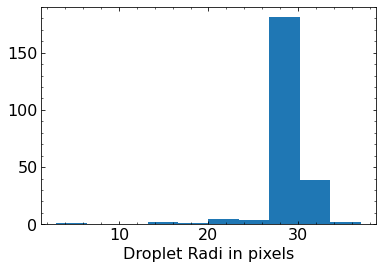

In [431]:
print(radi)
plt.hist(radi)
plt.xlabel('Droplet Radi in pixels')
plt.show()